## Preprocessing and EDA


In [1]:
from pathlib import Path
import os

data_path = Path("/home/mfclabber/fsoco_bounding_boxes_train")

def walk_through_dir(dir_path):
    """Walks through dir_path returning file counts of its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

walk_through_dir(data_path)

There are 41 directories and 1 files in '/home/mfclabber/fsoco_bounding_boxes_train'.
There are 2 directories and 0 files in '/home/mfclabber/fsoco_bounding_boxes_train/eufs'.
There are 0 directories and 125 files in '/home/mfclabber/fsoco_bounding_boxes_train/eufs/img'.
There are 0 directories and 125 files in '/home/mfclabber/fsoco_bounding_boxes_train/eufs/ann'.
There are 2 directories and 0 files in '/home/mfclabber/fsoco_bounding_boxes_train/ulm'.
There are 0 directories and 558 files in '/home/mfclabber/fsoco_bounding_boxes_train/ulm/img'.
There are 0 directories and 558 files in '/home/mfclabber/fsoco_bounding_boxes_train/ulm/ann'.
There are 2 directories and 0 files in '/home/mfclabber/fsoco_bounding_boxes_train/racetech'.
There are 0 directories and 244 files in '/home/mfclabber/fsoco_bounding_boxes_train/racetech/img'.
There are 0 directories and 244 files in '/home/mfclabber/fsoco_bounding_boxes_train/racetech/ann'.
There are 2 directories and 0 files in '/home/mfclabber/fso

Random image path: /home/mfclabber/fsoco_bounding_boxes_train/dhen/img/dhen_00106.png
Image height: 1522
Image width: 2488


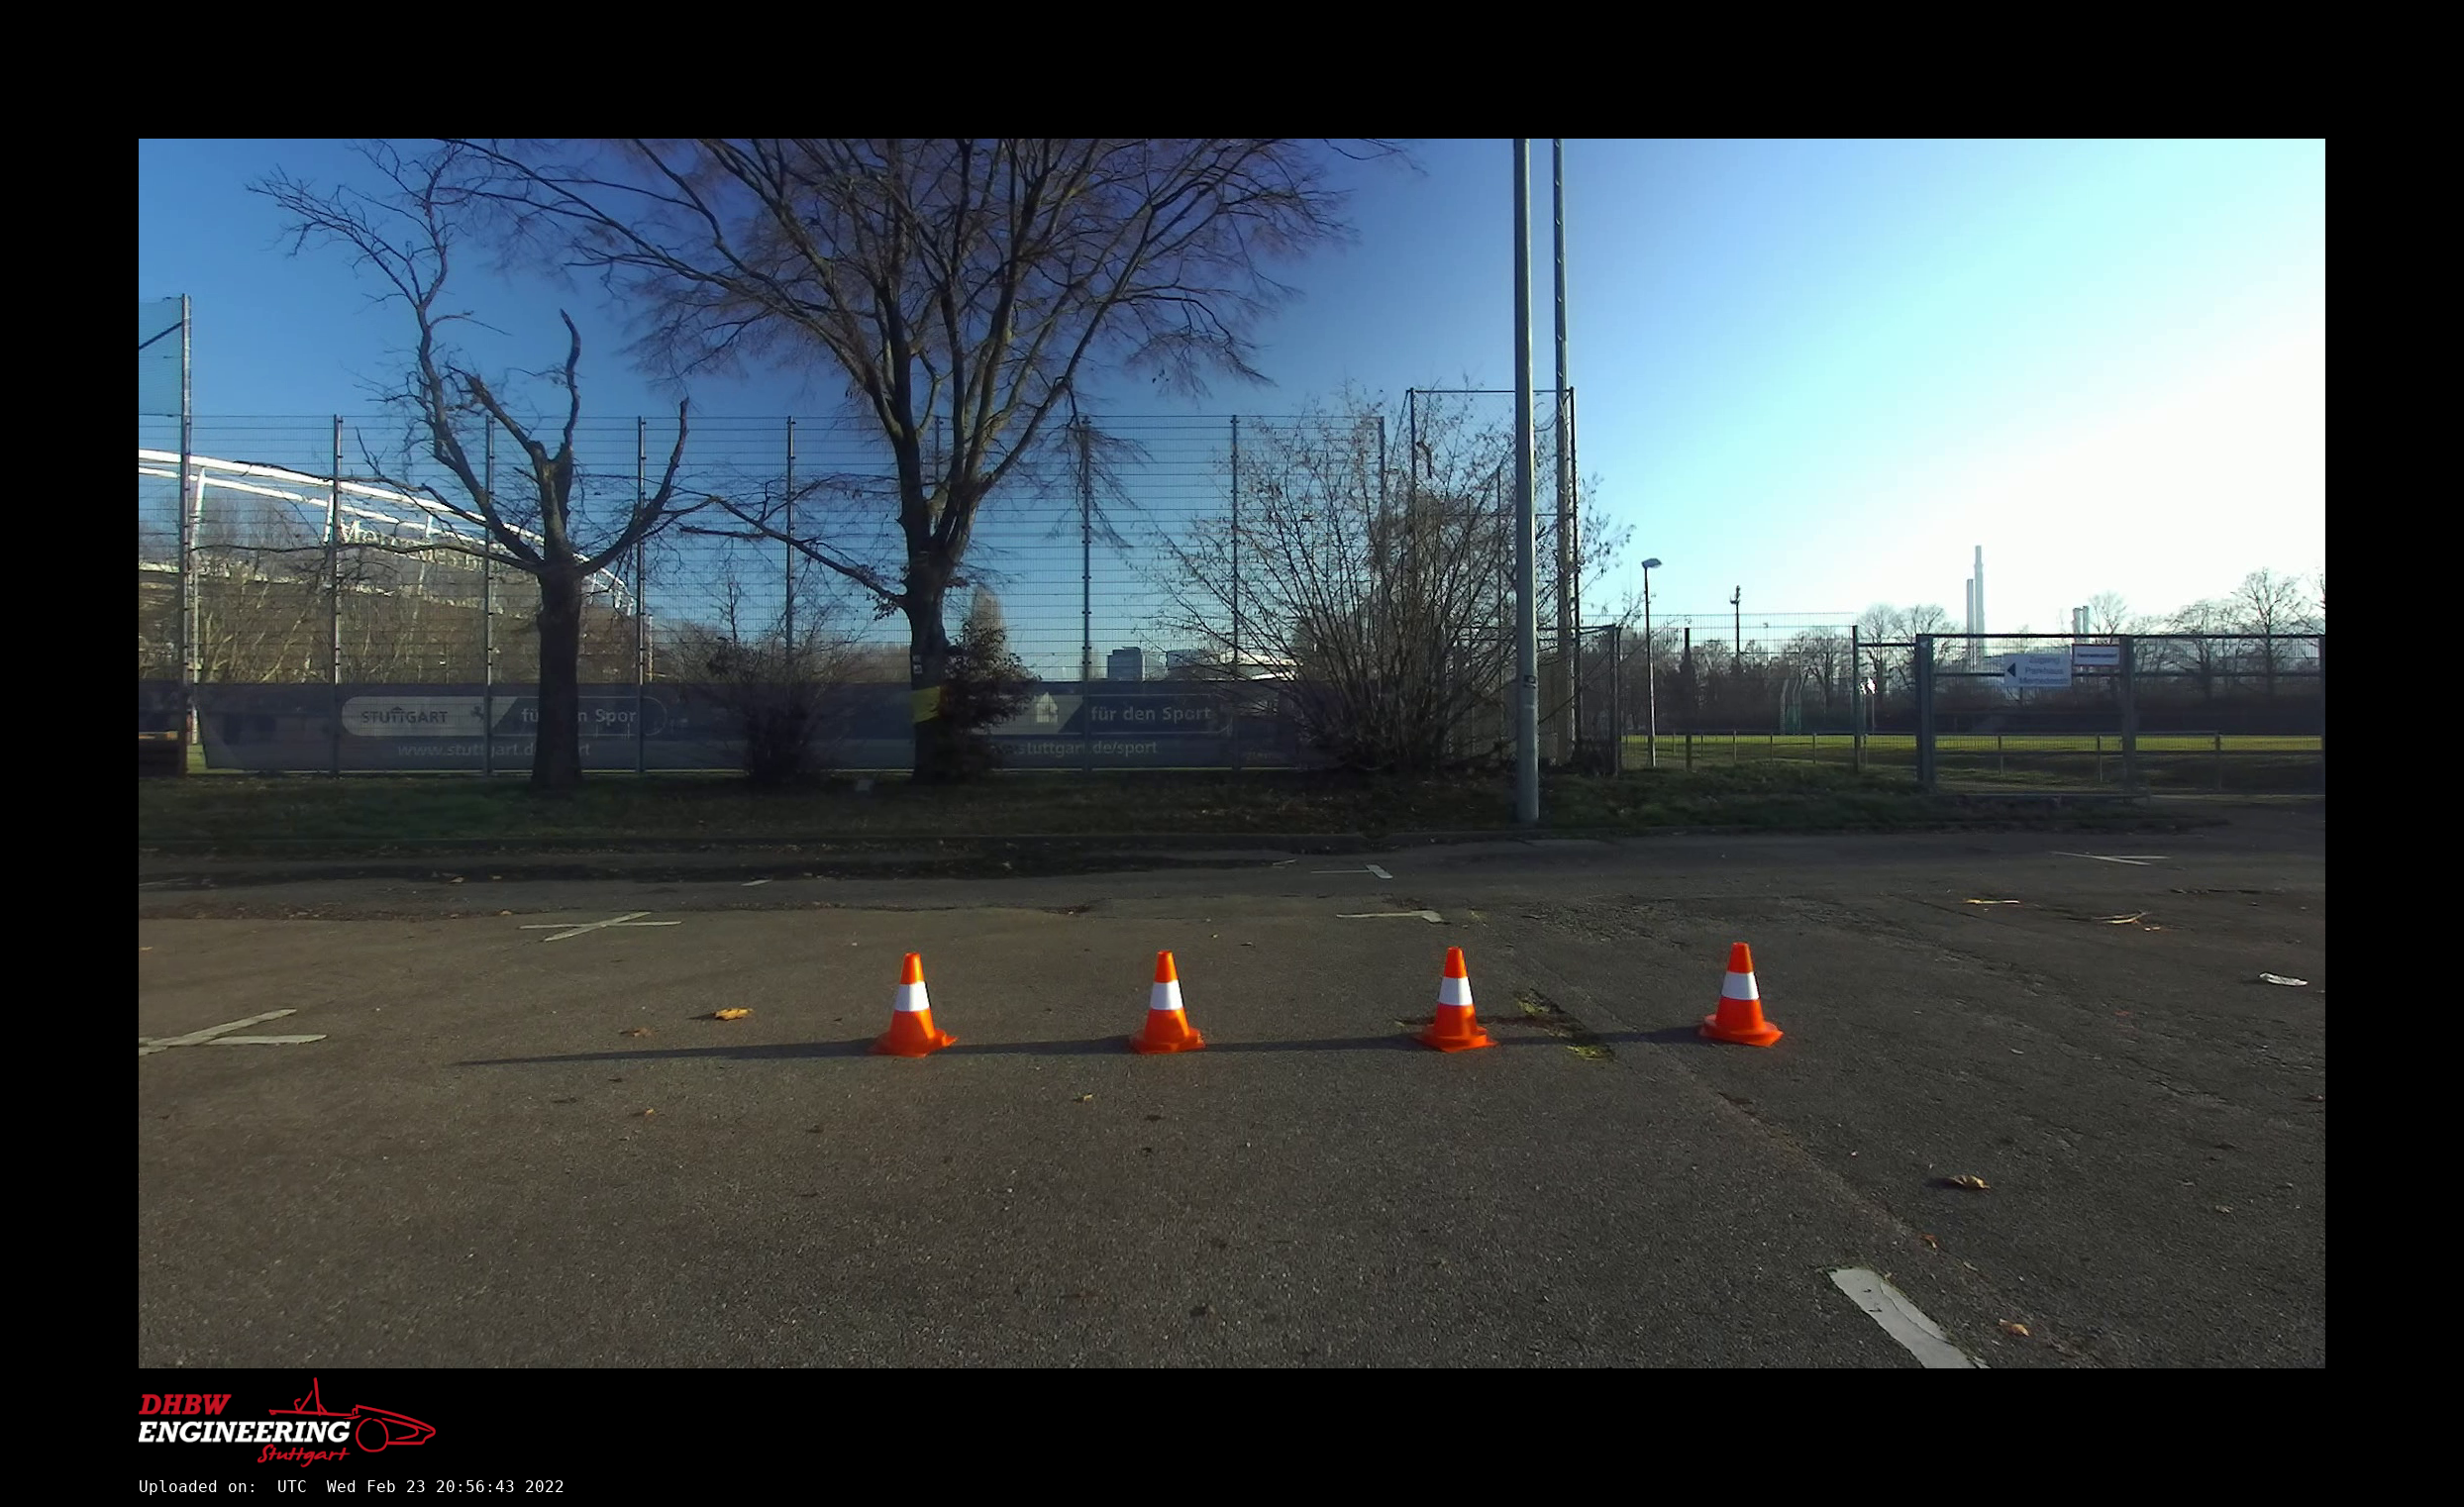

In [2]:
import random
from PIL import Image

image_path_list = sorted(list(data_path.glob("*/img/*.png")) +
                         list(data_path.glob("*/img/*.jpg")))

labels_path_list = sorted(list(data_path.glob("*/ann/*.json")))

random_image_path = random.choice(image_path_list)
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

In [3]:
import numpy as np
import torch
from PIL import ImageDraw

COLORS = dict([
    ("yellow_cone", (255, 255, 0)),
    ("blue_cone", (0, 0, 255)),
    ("large_orange_cone", (255, 122, 0)),
    ("orange_cone", (255, 122, 0)),
    ("unknown_cone", (255, 255, 255))
])

ID2LABEL = dict([
    (1, "yellow_cone"),
    (2, "blue_cone"),
    (3, "large_orange_cone"),
    (4, "orange_cone"),
    (0, "unknown_cone")
])


def objects_threshold_scores(bboxes: torch.Tensor, 
                         labels: torch.Tensor=None, 
                         scores: torch.Tensor=None,
                         threshold_score: float=0.3):
    bboxes_copy = copy.deepcopy(bboxes)
    labels_copy = copy.deepcopy(labels)
    scores_copy = copy.deepcopy(scores)

    bboxes = torch.Tensor([])
    labels, scores = list(), list()
    for i, score in enumerate(scores_copy):
        if score >= threshold_score:
            bboxes = torch.cat((bboxes, bboxes_copy[i].unsqueeze(dim=0)), dim=0)
            labels.append(labels_copy[i])
            scores.append(score)
    
#     bboxes = torch.Tensor(bboxes).unsqueeze(dim=0)
    labels = labels
    scores = torch.Tensor(scores)

    del bboxes_copy, labels_copy, scores_copy

    return bboxes, labels, scores

def show_image_with_objects(image: np.array, 
                            bboxes_: torch.Tensor, 
                            labels: torch.Tensor=None, 
                            scores: torch.Tensor=None,
                            depths_value: torch.Tensor=None,
                            threshold_score: float=0.3):
    
    if image.shape[2] > 3:
        image = image.transpose(1, 2, 0)

    image = Image.fromarray(image)
    if scores != None:
        bboxes_, labels, scores = objects_threshold_scores(bboxes_, labels, scores, threshold_score)
        
    for i in range(len(bboxes_)):
        bboxes = bboxes_[i].flatten()
        draw = ImageDraw.Draw(image)
    
        if type(labels[i]) == str:
            draw.rectangle(bboxes.numpy(), outline = COLORS[labels[i]], width=2)
        else:
            draw.rectangle(bboxes.numpy(), outline = COLORS[ID2LABEL[int(labels[i])]], width=2)

        if scores != None:
            # TODO
            if depths_value != None:
                # TODO: scores
                # bbox = draw.textbbox((bboxes[0], bboxes[1]), f"{ID2LABEL[int(labels[i])]}\n distance: {0}")
                # draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(0, 0, 0))
                if type(labels[i]) != str:
                    draw.text((bboxes[0], bboxes[1]-40), 
                            f"{ID2LABEL[int(labels[i])]}\n distance: {depths_value[i]:.2f}\n confidence: {scores[i]:.2f}", 
                            COLORS[ID2LABEL[int(labels[i])]])
                else:
                    draw.text((bboxes[0], bboxes[1]-40), 
                            f"{labels[i]}\n distance: {depths_value[i]:.2f}\n confidence: {scores[i]:.2f}", 
                            COLORS[labels[i]])
            else:
                if type(labels[i]) != str:
                    draw.text((bboxes[0], bboxes[1]-25), 
                              f"{ID2LABEL[int(labels[i])]}\n confidence: {scores[i]:.2f}", 
                              COLORS[ID2LABEL[int(labels[i])]])
                else:
                    draw.text((bboxes[0], bboxes[1]-25), 
                              f"{labels[i]}\n confidence: {scores[i]:.2f}", 
                              COLORS[labels[i]])
        else:
            if depths_value != None:
                # TODO: scores
                # bbox = draw.textbbox((bboxes[0], bboxes[1]), f"{ID2LABEL[int(labels[i])]}\n distance: {0}")
                # draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(0, 0, 0))
                draw.text((bboxes[0], bboxes[1]-40), 
                          f"{ID2LABEL[int(labels[i])]}\n distance: {depths_value[i]:.2f}", 
                          COLORS[ID2LABEL[int(labels[i])]])
            else:
                if type(labels[i]) != str:
                    draw.text((bboxes[0], bboxes[1]-15), 
                              f"{ID2LABEL[int(labels[i])]}", 
                              COLORS[ID2LABEL[int(labels[i])]])
                else:
                    draw.text((bboxes[0], bboxes[1]-15), 
                              f"{labels[i]}", 
                              COLORS[labels[i]])
    return image

# image = Image.open(image_path_list[0])
# show_image_with_objects(np.array(image.convert('RGB')), torch.Tensor(bboxes), labels)

## Import libraries

In [4]:
import os
import cv2
import random
import pathlib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

from roboflow import Roboflow

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from sklearn.model_selection import train_test_split

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import PIL
from PIL import Image, ImageFile, ImageFont, ImageDraw, ImageEnhance
ImageFile.LOAD_TRUNCATED_IMAGES = True

import copy
import json
import random
from time import time

import warnings
warnings.filterwarnings('ignore')

FUSED_SHAPE = (1280, 640)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/mfclabber/anaconda3/envs/ml_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


## Preparing dataset

In [5]:
class FS_COCO_Dataset(Dataset):
    def __init__(self, 
                 images_pathes_list: pathlib.Path, 
                 annotations: pathlib.Path,
                 transform: torchvision.transforms=None) -> None:
        
        self.images_pathes_list = images_pathes_list
        self.annotations = annotations
        self.transform = transform
        self.num_classes = 4

    def __getitem__(self, index: int):
        "Returns one sample of data: image, target[labels, bboxes]"
        
        image = Image.open(self.images_pathes_list[index]).convert('RGB')

        image, offsets = self.trim_black_borders(image.copy())
        image = np.array(image)
        
        bboxes, labels, idx = self.parse_json_annotations(self.annotations[index])
        labels = [list(ID2LABEL.keys())[list(ID2LABEL.values()).index(label)] for label in labels]
        
        for coordinates in bboxes:
            coordinates[0] -= offsets[0]
            coordinates[1] -= offsets[1]
            coordinates[2] -= offsets[0]
            coordinates[3] -= offsets[1]
        
        if self.transform:
            transformed = self.transform(image = image, bboxes = bboxes, labels = labels)
            image = np.array(transformed['image']).transpose(1, 2, 0)
            bboxes = transformed['bboxes']
            labels = transformed['labels']
            
        target = dict()
        target['boxes'] = torch.as_tensor(bboxes, dtype=torch.float)
        target['labels'] = torch.as_tensor(labels, dtype=torch.int64)
        
        if target['boxes'].shape == torch.Size([0]):
            target['boxes'] = torch.Tensor([0, 0, 1e-10, 1e-10]).unsqueeze(dim=0)
            
        if target['labels'].shape == torch.Size([0]):
            target['labels']= torch.zeros(size=(1, ), dtype=torch.int64)
    
        return image.transpose(2, 0, 1), target


    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.images_pathes_list)
    
    @staticmethod
    def parse_json_annotations(json_path: pathlib.Path) -> List[np.ndarray]:
        bboxes, labels, idx = list(), list(), list()
        with open(json_path, 'r') as j:
            parsed_data = json.loads(j.read())

#             description = parsed_data["description"]
#             tags = parsed_data["tags"]
#             size = parsed_data["size"]
            objects = parsed_data["objects"]

            for obj in objects:
                bboxes.append(np.array(obj["points"]["exterior"]).flatten())
                labels.append(obj["classTitle"])
                idx.append(obj['id'])
                
        return np.array(bboxes), np.array(labels), np.array(idx)
    
    @staticmethod
    def trim_black_borders(image: PIL.Image, tolerance=10):

        pixels = image.load()
        width, height = image.size

        def is_black(pixel):
            return all(channel <= tolerance for channel in pixel)

        left = 0
        right = width - 1
        top = 0
        bottom = height - 1

        for x in range(width):
            if any(not is_black(pixels[x, y]) for y in range(height)):
                left = x
                break

        for x in range(width - 1, -1, -1):
            if any(not is_black(pixels[x, y]) for y in range(height)):
                right = x
                break

        for y in range(height):
            if any(not is_black(pixels[x, y]) for x in range(width)):
                top = y
                break

        for y in range(height - 1, -1, -1):
            if any(not is_black(pixels[x, y]) for x in range(width)):
                bottom = y
                break

        cropped_image = image.crop((left, top, right + 1, bottom + 1))
        
        return cropped_image, (left, top, right + 1, bottom + 1)

## Train and test data transforms

In [6]:
train_transforms = albumentations.Compose(
    [
        albumentations.Resize(height=FUSED_SHAPE[1], width=FUSED_SHAPE[0]),
        albumentations.HorizontalFlip(p=0.2),
        albumentations.Rotate(p=0.5),
        # albumentations.Blur(p=0.3),
        # albumentations.CLAHE(p=0.3),
        # albumentations.ToGray(p=0.1),
        # albumentations.MedianBlur(p=0.1),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels'])
)

test_transforms = albumentations.Compose(
    [
        albumentations.Resize(height=FUSED_SHAPE[1], width=FUSED_SHAPE[0]),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels'])
)

## Create model

In [24]:
class YOLOv6(torch.nn.Module):
    def __init__(self, num_classes: int=4) -> None:
        super().__init__()

        rf = Roboflow(api_key="O2GZHfT0IgWwA2lVCZrr")
        project = rf.workspace().project("yolov6-training-segment-2")
        self.model = project.version(6).model

        self.LABEL2LABEL = dict([
            ("orange_cone", "blue_cone"),
            ("blue_cone", "yellow_cone"),
            ("large_orange_cone", "large_orange_cone"),
            ("yellow_cone", "blue_cone")
        ])

    def predict(self, X: torch.Tensor, confidence=40, overlap=30) -> torch.Tensor:
        boxes = []
        scores = []
        labels = []

        result = self.model.predict(X.transpose(1, 2, 0), confidence=40, overlap=30).json()

        for prediction in result['predictions']:
            x, y, width, height = prediction['x'], prediction['y'], prediction['width'], prediction['height']
            boxes.append([x - width / 2, y - height / 2, x + width / 2, y + height / 2,])  # Преобразуем в формат [xmin, ymin, width, height]
            scores.append(prediction['confidence'])
            labels.append(self.LABEL2LABEL[prediction['class']])
        return torch.Tensor(boxes), labels, scores
    
    # To calculate the loss function
    def forward(self, images: List[torch.Tensor], annotation: List[Dict[str, torch.Tensor]]) -> Dict[str, int]:
        return self.model(images, annotation)

## Splitting data

In [8]:
train_data, test_data = train_test_split(list(zip(image_path_list, labels_path_list)), test_size=0.3, shuffle=True, random_state=42)
val_data, data_data = train_test_split(test_data, test_size=0.1, shuffle=True, random_state=42)

train_data = FS_COCO_Dataset(list(items[0] for items in train_data),
                             list(items[1] for items in train_data),
                             transform=train_transforms)

test_data = FS_COCO_Dataset(list(items[0] for items in test_data),
                            list(items[1] for items in test_data),
                            transform=test_transforms)

val_data = FS_COCO_Dataset(list(items[0] for items in val_data),
                           list(items[1] for items in val_data),
                           transform=test_transforms)

## Inference

In [28]:
model = YOLOv6()

image, target = random.choice(test_data)
print(image.shape)
bboxes, labels, scores = model.predict(image, confidence=40, overlap=30)
print(scores)
show_image_with_objects(image, bboxes, labels, scores, threshold_score=0.4)

loading Roboflow workspace...
loading Roboflow project...
(3, 640, 1280)


HTTPError: 403 Client Error: Forbidden for url: https://detect.roboflow.com/yolov6-training-segment-2/6?api_key=O2GZHfT0IgWwA2lVCZrr&name=YOUR_IMAGE.jpg&overlap=30&confidence=40&stroke=1&labels=false&format=json

In [17]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import monodepth2.networks as networks
from monodepth2.utils import download_model_if_doesnt_exist

model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval()

DepthDecoder(
  (decoder): ModuleList(
    (0-1): 2 x ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (2-3): 2 x ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (4-5): 2 x ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (6): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (7): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1)

In [26]:
def prediction(image: torch.Tensor, model, threshold_score=0.3):
    input_image = Image.fromarray(image.transpose(1, 2, 0))
    original_width, original_height = input_image.size

    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)


    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)

    disp = outputs[("disp", 0)]


    disp_resized = torch.nn.functional.interpolate(disp,
        (original_height, original_width), mode="bilinear", align_corners=False)

    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    def get_cone_distances(detected_cones, depth_map):
        distances = []
        
        for bbox in detected_cones:
            x1, y1, x2, y2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])

            depth_crop = depth_map[y1:y2, x1:x2]
            avg_depth = np.mean(depth_crop)
            distances.append(avg_depth)
        
        return distances

    bboxes, labels, scores = model.predict(image, confidence=30, overlap=30)

    res = get_cone_distances(bboxes, 1 / disp_resized_np)

    return show_image_with_objects(image, 
                                   bboxes, 
                                   labels, 
                                   scores, 
                                   depths_value=res, 
                                   threshold_score=threshold_score)

In [27]:
image, target = random.choice(test_data)
print(image.shape)
prediction(image, model)

(3, 640, 1280)


AttributeError: 'YOLOv6' object has no attribute 'model'

## Validate on test images

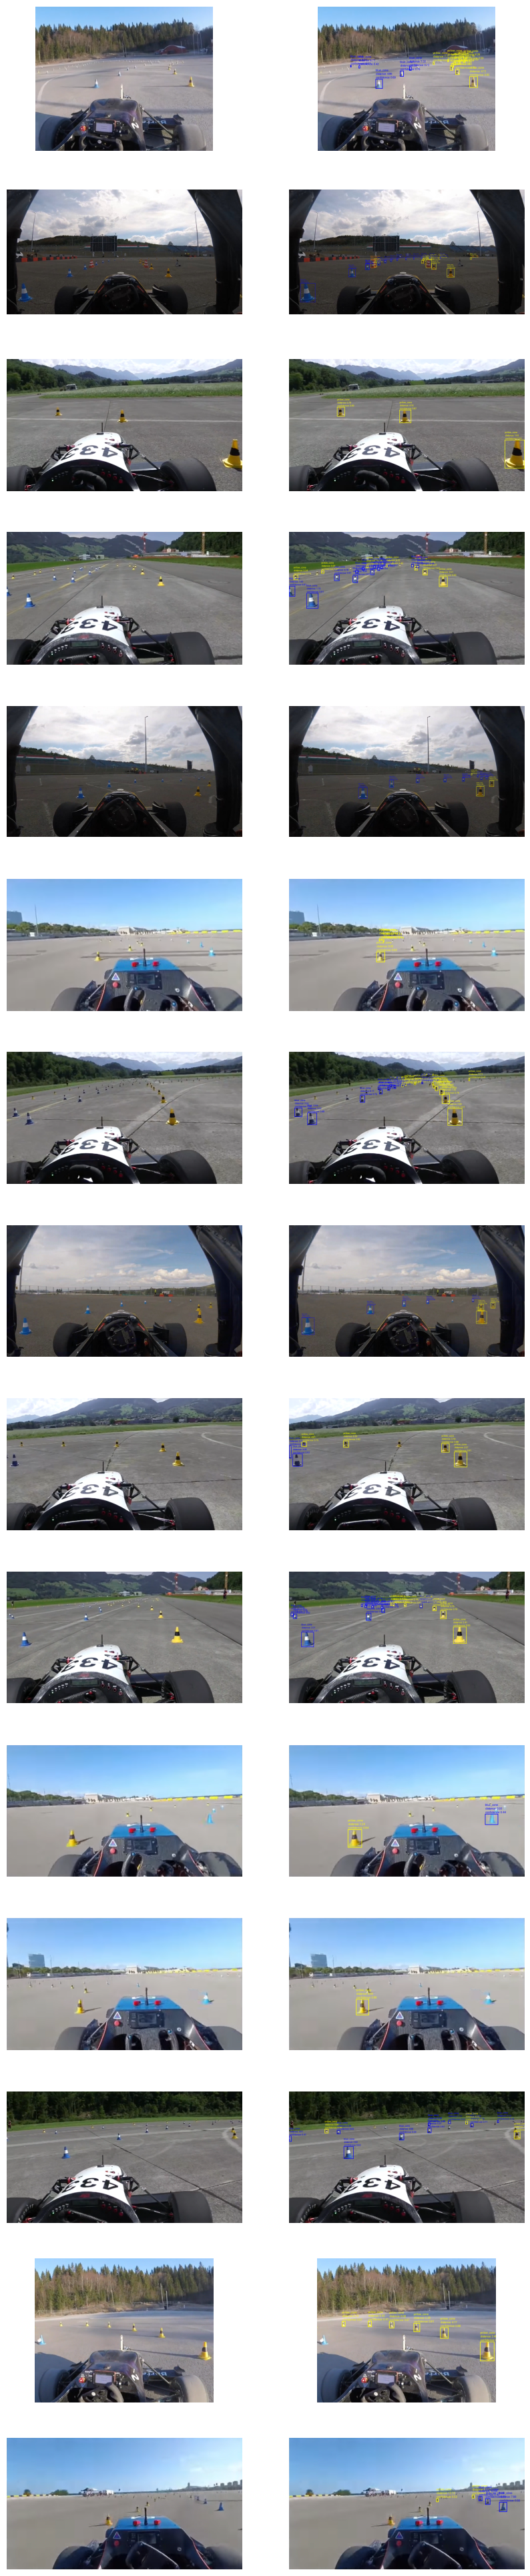

In [14]:
test_data_path = Path("fs_test_set")
path2assets = Path("assets_test_set")

test_image_path_list = sorted(list(test_data_path.glob("*.png")) +
                              list(test_data_path.glob("*.jpg")))

fig, axes = plt.subplots(len(test_image_path_list), 2, figsize=(10, 50))

for i, axis in enumerate(axes):
    axis[0].imshow(Image.open(test_image_path_list[i]))
    axis[0].axis(False)

    pred_image = prediction(np.array(Image.open(test_image_path_list[i])).transpose(2, 0, 1)[:3])
    pred_image.save(f"{path2assets}/pred_{str(test_image_path_list[i]).split('/')[-1]}")

    axis[1].imshow(pred_image)
    axis[1].axis(False)

# plt.subplots_adjust(wspace=0, hspace=0)

In [51]:
import time
import io
from IPython.display import display, clear_output

def process_frame(frame, model):
    # Сохраняем временный файл для текущего кадра
    # temp_filename = 'temp_frame.jpg'
    # cv2.imwrite(temp_filename, frame)

    # Предсказание модели на кадре
    annotated_frame = prediction(np.array(frame).transpose(2, 0, 1)[:3])

    return np.array(annotated_frame)

# Функция для расчета FPS
def calculate_fps(start_time, num_frames):
    elapsed_time = time.time() - start_time
    fps = num_frames / elapsed_time
    return fps

# Открытие видеофайла
video_path = 'videos/office.mp4'  # Укажите путь к вашему видеофайлу
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Ошибка открытия видеофайла")
    exit()

# Параметры видео
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Размер видео: {frame_width}x{frame_height}, FPS: {fps}, Количество кадров: {total_frames}")

# Создание объекта VideoWriter для сохранения видео
output_video_path = 'output_video.mp4'  # Укажите путь для сохранения видео
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Кодек для MP4
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Начало обработки видео
start_time = time.time()
num_frames = 0
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    frame_count += 1

    num_frames += 1
    current_fps = calculate_fps(start_time, num_frames)

    if frame_count % 5 == 0:
        # Обработка кадра
        annotated_frame = process_frame(frame, model)

        # Расчет и вывод текущего FPS
        # num_frames += 1
        # current_fps = calculate_fps(start_time, num_frames)
        cv2.putText(annotated_frame, f"FPS: {current_fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        out.write(cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR))

        # Преобразование кадра для отображения в Jupyter
        _, img_encoded = cv2.imencode('.jpg', cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR))
        img_bytes = io.BytesIO(img_encoded)
        img_pil = Image.open(img_bytes)

        # Очистка предыдущего вывода и вывод текущего кадра
        clear_output(wait=True)
        display(img_pil)
        # Задержка, чтобы контролировать скорость воспроизведения видео
    time.sleep(1 / fps)

# Завершение обработки видео
cap.release()
out.release()  # Завершение записи видео
print(f"Видео сохранено как {output_video_path}")
# Image.fromarray(annotated_frame)

Размер видео: 1920x1080, FPS: 30.002262944407, Количество кадров: 274


HTTPError: 403 Client Error: Forbidden for url: https://detect.roboflow.com/yolov6-training-segment-2/6?api_key=O2GZHfT0IgWwA2lVCZrr&name=YOUR_IMAGE.jpg&overlap=30&confidence=40&stroke=1&labels=false&format=json

In [39]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')